# Reconstruction of DOSY NMR signals - Part I

In [3]:
import warnings
warnings.filterwarnings('ignore')

The measurement of diffusion by Nuclear Magnetic Resonance (NMR) is used in various application fields (agro-alimentary, pharmaceutical, ecology) to analyze the properties of complex chemical mixtures in order to determine their molecular structure and dynamics. After the immersion of the matter in a strong magnetic field, all the nuclear spins align to an equilibrium state along the field orientation. The application of a short magnetic pulse, i.e. the pulsed field gradient, in resonance with the spin motion disturbs the spin orientation. NMR aims at analyzing the process which corresponds to the re-establishment of the spin into its equilibrium state. During the DOSY (Diffusion Order SpectroscopY) experiment, proposed by Morris and Johnson in 1992, a series of measurements is acquired for different pulsed field gradient strengths, the data are then analyzed with the aim to separate different species according to their diffusion coefficient.

## Package imports

In [4]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as sp

## Generation of synthetic data

Text(0.5, 1.0, 'Noisy data as a function of t')

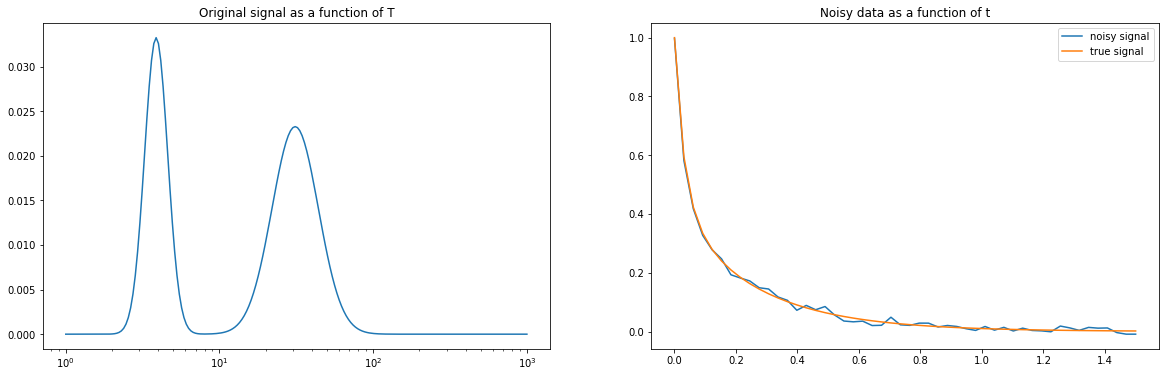

In [267]:
data = np.loadtxt('data.txt')
T = np.exp(-(np.linspace(1,200,200)-1)*np.log(1/1000)/199)   

fig,a = plt.subplots(1,2, figsize=(20,6))
a[0].plot(T,data)
a[0].set_xscale('log')
a[0].set_title('Original signal as a function of T')

t = 1.5*((np.linspace(1,50,50)-1)/49)
K = np.exp(-np.outer(t,T))

signal = K.dot(data)
omega = np.random.normal(0,0.01*signal[0],50)
noisy = signal + omega

a[1].plot(t,noisy,label='noisy signal')
a[1].plot(t,signal, label='true signal')
a[1].legend()
a[1].set_title('Noisy data as a function of t')


## Comparison of regularization strategies

In [268]:
def Normalized_quadratic_error(x, x_estim):
    return np.linalg.norm(x-x_estim)**2/np.linalg.norm(x)**2

### 1 - Smoothness prior

In this case, the regularisation term is is intended to promote the reconstruction of a smooth signal.

$$ \forall x \in R^{N},  g(x) = \frac{1}{2}\|Dx\| $$

with D the discrete gradient operator defined as $ \forall n \in \{1...N\}, D^{n}x=x^{n} - x^{n-1}$$ and $$ x^{0} = x^{N}.$ The function $F_{K,\beta} : R^{N} -> R$ defined over the finite-dimensional Hilbert space $R^{N}$ by,


$$F_{K,\beta}(x) = \frac{1}{2}\|Kx - y \|^{2}_{2} + \frac{\beta}{2}\|Dx\|^{2}_{2}$$ 

is twice differentiable over $R^{N}$ and the gradient is equal to $\nabla F_{K,\beta}(x) = (K^{t}K + \beta D^{t}D)x - K^{t}y$ and the hessian to $\nabla^{2} F_{K,\beta}(x) = K^{t}K + \beta D^{t}D$


By construction, this form is define positive and $F_{K,\beta}$ is strictly convex on $R^{N}$ so there exist a unique minimizer that admits a closed form which cancel out the gradient

$$argmin_{R^{N}} F_{K,\beta}(x) = (K^{t}K + \beta D^{t}D)^{-1}K^{t}y$$

In the following cell, we compute the minimizer for different values of the regularization paramter $\beta$ and plot the reconstructed signal with the normalized error. 

**The best choice of parameter w.r.t to this error is $\beta$ = 0.7**

[(0.1, 0.7373580531539788),
 (0.16681005372000587, 0.5040326539885681),
 (2.1544346900318834, 0.23933400585063277),
 (3.593813663804626, 0.3018390364365718),
 (0.46415888336127786, 0.1994834267330531),
 (1.291549665014884, 0.17932891153027536),
 (10.0, 0.3824233986885417),
 (0.2782559402207124, 0.32139278266100646),
 (0.774263682681127, 0.1550254261814814),
 (5.994842503189409, 0.35010686970758587)]

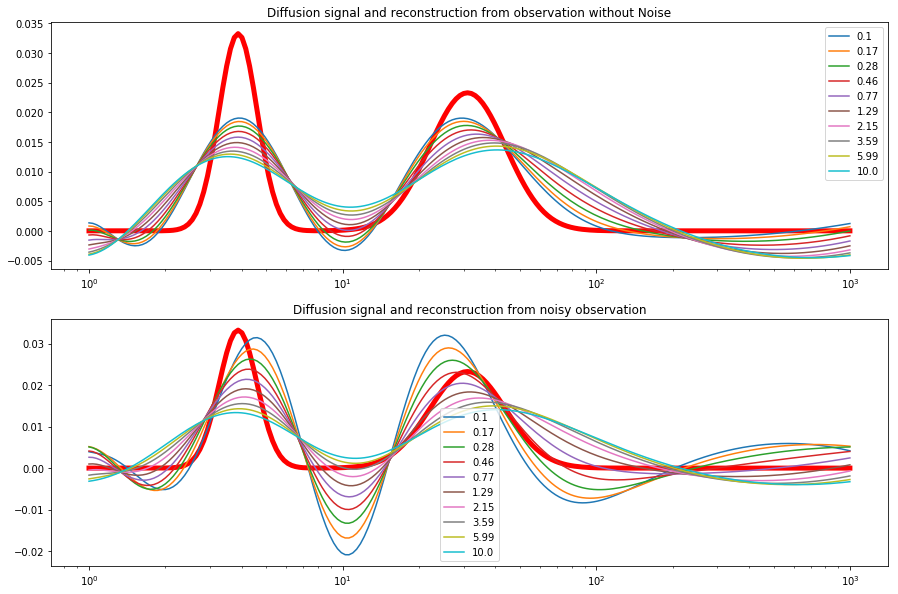

In [269]:
beta = 1
N=200
    
D = np.eye(N) - np.eye(N, k=-1)
D[0,N-1] = -1

f, ax = plt.subplots(2, 1, figsize=(15,10))
ax[0].set_xscale('log')
ax[0].set_title('Diffusion signal and reconstruction from observation without Noise')
ax[0].plot(T,data,linewidth=5, color='red')

errors = {}
for beta in np.logspace(-1,1,10):
    x_reconstructed = np.linalg.inv(K.T.dot(K) + beta*D.T.dot(D)).dot(K.T).dot(signal)
    errors[beta] = Normalized_quadratic_error(data,x_reconstructed)
    ax[0].plot(T, x_reconstructed,label='{}'.format(round(beta,2)))
ax[0].legend()
    
ax[1].set_xscale('log')
ax[1].set_title('Diffusion signal and reconstruction from noisy observation')
ax[1].plot(T,data,linewidth=5, color='red')

errors = {}
for beta in np.logspace(-1,1,10):
    x_reconstructed = np.linalg.inv(K.T.dot(K) + beta*D.T.dot(D)).dot(K.T).dot(noisy)
    errors[beta] = Normalized_quadratic_error(data,x_reconstructed)
    ax[1].plot(T, x_reconstructed,label='{}'.format(round(beta,2)))
ax[1].legend()
    
list(errors.items())

**NB**: The impact of the additive noise in the signal is obvious on the reconstruction using a smoothness prior.

### 2 - Smoothness + constraint : Projected gradient descent

In the second case, the smoothing regularisation term is completed with constraints on the space of acceptable values $C= [min(x_{signal}),max(x_{signal})]^{N}$.

$$ \forall x \in R^{N},  g(x) = \frac{1}{2}\|Dx\|^{2}_{2} + 1_C(x)$$

Since the function $F_{K,\beta}(x) = \frac{\beta}{2}\|Kx - y \|^{2}_{2} + \frac{\beta}{2}\|Dx\|^{2}_{2}$ is continuous and strictly convex on the compact C (a bounded closed set of a finite-dimensional space) the function admits a unique minimizer. The form of the problem can be rewritten as:


$$argmin_{C} F_{K,\beta}(x) =  argmin_{R^{N}}\frac{1}{2}\|Kx - y \|^{2}_{2}+\frac{\beta}{2}\|Dx\|^{2}_{2} + 1_C(x)$$ 

This problem can be solved by the projected gradient algorithm since C is a non_empty closed convex set of the Hilbert space $R^{N}$ and $F_{K,\beta}$ is a differentiable function with $\nu$-Lipzitschian gradient where

$$\nu = \max(\lambda | \lambda \in Spectre(K^{t}K + \beta D^{t}D))$$

In order to implement this algorithm, we use a sequence $\lambda$ that slowly decrease every 1000 iterations in order to adapt the rate of convergence of the sequence.

Hence, we can constructe a sequence $(x_n)_N$ that converges weakly (hence strongly in $R^{N}$) to the unique minimizer of $F_{K,\beta}$ over C.

Here the normalized error of our estimation under projected gradient is affected marginally by the regularization setting, while $\beta$ = **0.01** is the best parameter.

nu=478.3799614500914, gamma=0.0041393832923091005, delta=1.00990099009901, beta=0.0001
10000 1.9839271216571002e-05 1e-06
20000 8.316691819804577e-06 1e-06
30000 5.3634908330634695e-06 1e-06
40000 3.929368944366634e-06 1e-06
nu=478.3799659462421, gamma=0.0041393832534042715, delta=1.00990099009901, beta=0.00031622776601683794
10000 1.9840692311463423e-05 1e-06
20000 8.318391415220154e-06 1e-06
30000 5.364981526203104e-06 1e-06
40000 3.930984587982547e-06 1e-06
nu=478.3799801643732, gamma=0.004139383130375934, delta=1.00990099009901, beta=0.001
10000 1.984518587261355e-05 1e-06
20000 8.323764679312912e-06 1e-06
30000 5.369692192530409e-06 1e-06
40000 3.9360847583449816e-06 1e-06
nu=478.3800251265857, gamma=0.004139382741321596, delta=1.00990099009901, beta=0.0031622776601683794
10000 1.985939243808524e-05 1e-06
20000 8.340722693090284e-06 1e-06
30000 5.3845564425689845e-06 1e-06
40000 3.952128567639778e-06 1e-06
nu=478.3801673149257, gamma=0.004139381510978031, delta=1.00990099009901, b

[(0.0001, 0.052638913466220814),
 (0.01, 0.052452987390811265),
 (0.00031622776601683794, 0.052634430040872246),
 (0.001, 0.05262036662544564),
 (0.0031622776601683794, 0.0525770743085742)]

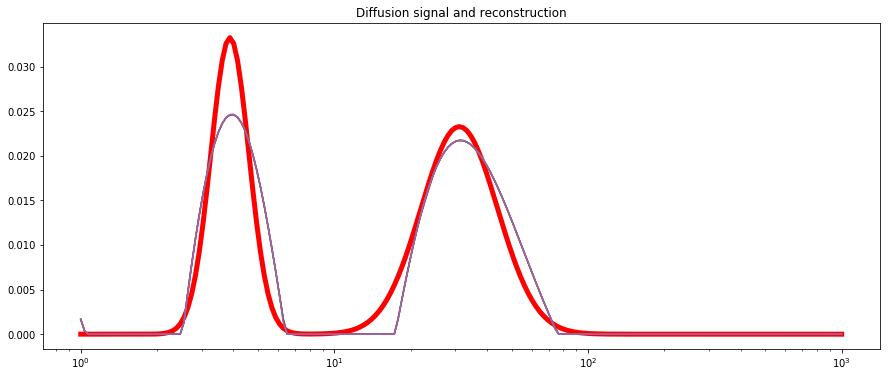

In [273]:
def Projected_gradient(signal, K=K, D=D, beta=1, lambda_= 1/2, tol= 1e-5):
    
    nu = np.max(np.linalg.eigvals(K.T.dot(K) + beta*D.T.dot(D)))
    gamma = 2/(nu*1.01)
    delta = 2 - gamma*nu/2    
    print('nu={}, gamma={}, delta={}, beta={}'.format(nu,gamma,delta,beta))
                 
    grad_g = lambda x: K.T.dot(K).dot(x) + beta*D.T.dot(D.T).dot(x) - K.T.dot(signal)
    proj_C = lambda x: np.clip(x, np.min(data),np.max(data))
                         
    tolerance=1
                 
    x_n = np.zeros(200) #np.random.uniform(0,1,200)
    count=0
                         
    while tolerance > tol and count<40000:
        count+=1
        if count%1000==0:
            lambda_=lambda_*0.99
        if count%10000==0:
            print(count, tolerance, tol)
                         
        y_n = x_n - gamma*grad_g(x_n)
        x_n1 = x_n + lambda_*(proj_C(y_n)-x_n)   
        tolerance = np.linalg.norm(x_n1 - x_n,1)/np.linalg.norm(x_n,1)
        x_n = x_n1
                 
    return x_n

#Projected_gradient(noisy, K=K, D=D, c1=0, c2=1,  beta=1, gamma=1, lambda_= 1/2, tol= 1e-6)
f, ax1 = plt.subplots(1, 1, figsize=(15,6))
ax1.set_xscale('log')
ax1.set_title('Diffusion signal and reconstruction')
ax1.plot(T,data,linewidth=5, color='red')


errors = {}
for beta in np.logspace(-4,-2,5):
    x_reconstructed = Projected_gradient(noisy, K=K, D=D,beta=beta,lambda_= 1/2, tol=1e-6)
    errors[beta] = Normalized_quadratic_error(data,x_reconstructed)
    ax1.plot(T, x_reconstructed)
    
list(errors.items() )

### 3 - Sparsity prior :

In the last case, we replace the smoothness regularization with a sparsity constraint by adding the $l_1$ norm that is in $\Gamma_0(H)$

$$ \forall x \in R^{N},  f(x) = \|x\|_1$$

The function $g(x) = \frac{1}{2}\|Kx - y \|^{2}_{2}$ is also in $\Gamma_0(H)$ and as stated previously, differentiable with a gradient that is $\nu$-Lipzitschian ($\nu$ = max{$\lambda$ for $\lambda$ in Spectre($K^{t}K$)) $\in R^{+}$).Hence, since Argmin(f + g) ≠ {}, the problem can be solved by using forward-backward algorithm to obtain a sequence that weakly converges to a minimizer of f+g, using the fact that:

$$\text{prox}_{\gamma \beta |x|}(\psi) = \text{sign}(\psi) \text{max}(|\psi| - \gamma \beta, 0)$$

**The best hyperparameter setting is here $\beta$ = 0.01.**

In [299]:
def Forward_Backward(signal, K=K, beta=1, lambda_= 1/2, tol= 1e-5):
    
    nu = np.max(np.abs(np.linalg.eigvals(K.T.dot(K))))
    gamma = 2*(1/nu - 1e-5) 
    delta = 2 - gamma*nu/2    
    print('nu={}, gamma={}, delta={}, beta={}'.format(nu,gamma,delta,beta))
                 
    grad_g = lambda x: K.T.dot(K).dot(x) - K.T.dot(signal)
    prox_f = lambda x: np.sign(x)*(np.clip(np.abs(x)-gamma*beta,0,np.inf))
    #prox_f = lambda x: np.sign(x)*(np.maximum(np.abs(x)-gamma*beta,0))                    
    
    tolerance=1
                 
    x_n = np.zeros(200) #np.random.uniform(0,1,200)
    count=0
                         
    while tolerance > tol and count < 40000:
        count+=1
        if count%10000==0:
            print(count, tolerance, tol)
        if count%1000==0:
            lambda_=lambda_*0.99
                         
        y_n = x_n - gamma*grad_g(x_n)
        x_n1 = x_n + lambda_*(prox_f(y_n)-x_n)   
        tolerance = np.linalg.norm(x_n1 - x_n,1)/np.linalg.norm(x_n,1)
        x_n = x_n1
                 
    return x_n

nu=478.37995937073583, gamma=0.004160777143404614, delta=1.0047837995937074, beta=0.0001
10000 2.896102080396677e-05 1e-08
20000 1.215116201601057e-05 1e-08
30000 6.693825009652298e-06 1e-08
40000 5.2784902667334225e-06 1e-08
nu=478.37995937073583, gamma=0.004160777143404614, delta=1.0047837995937074, beta=0.00031622776601683794
10000 2.5429920637769104e-05 1e-08
20000 1.0499944161262362e-05 1e-08
30000 6.5920246349586185e-06 1e-08
40000 4.5258706949777834e-06 1e-08
nu=478.37995937073583, gamma=0.004160777143404614, delta=1.0047837995937074, beta=0.001
10000 2.6576373449683386e-05 1e-08
20000 8.967330348724528e-06 1e-08
30000 5.859143201833936e-06 1e-08
40000 4.477206379416708e-06 1e-08
nu=478.37995937073583, gamma=0.004160777143404614, delta=1.0047837995937074, beta=0.0031622776601683794
10000 1.896393397051901e-05 1e-08
20000 8.82946823716801e-06 1e-08
30000 5.799048202821299e-06 1e-08
40000 4.055590549531566e-06 1e-08
nu=478.37995937073583, gamma=0.004160777143404614, delta=1.004783

[(0.0001, 0.08220611321172316),
 (0.01, 0.04326769292897815),
 (0.00031622776601683794, 0.05565269967496049),
 (0.001, 0.051475297347857135),
 (0.0031622776601683794, 0.04663353423243167)]

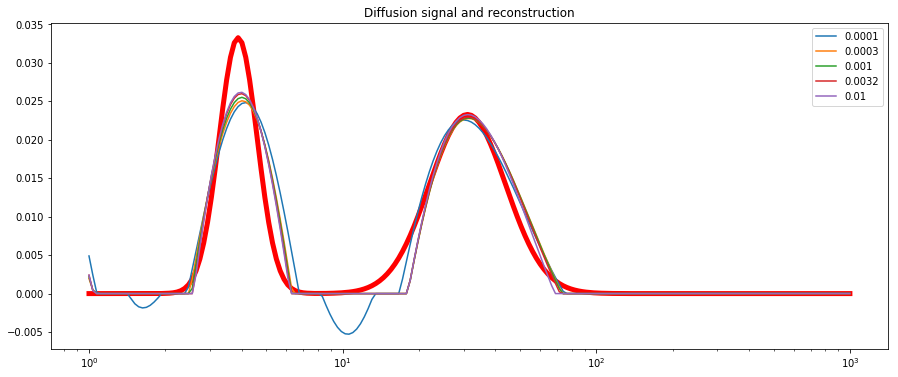

In [300]:
f, ax1 = plt.subplots(1, 1, figsize=(15,6))
ax1.set_xscale('log')
ax1.set_title('Diffusion signal and reconstruction')
ax1.plot(T,data,linewidth=5, color='red')

errors = {}
for beta in np.logspace(-4,-2,5):
    x_reconstructed = Forward_Backward(noisy, K=K, beta=beta,lambda_= 1/1.5, tol= 1e-8)
    errors[beta] = Normalized_quadratic_error(data,x_reconstructed)
    ax1.plot(T, x_reconstructed, label='{}'.format(round(beta,4)))
ax1.legend()

list(errors.items() )

# Reconstruction of DOSY NMR signals - Part II

In the context of DOSY NMR data processing, a standard strategy for restoring the target signal is to define it as the solution of the so-called maximum entropy
problem: 

$$F_{K,\beta}(x) = \frac{1}{2}\|Kx - y \|^{2}_{2} + \beta ent(x)$$ 

__Answer 1 to 3__


> Let $x, y \in [0, + \infty ]$ and $\lambda \in [0, 1]$.  $\varphi(\lambda x + (1 - \lambda)y) = (\lambda x + (1 - \lambda)y)\log(\lambda x + (1 - \lambda)y) =\lambda x \log(\lambda x + (1 - \lambda)y) + (1 - \lambda)y\log(\lambda x + (1 - \lambda)y) \leq \lambda \varphi(x) + (1 - \lambda) \varphi(y)$ so $\varphi$ is convex over R.

> $\varphi$ is clearly proper over R.

> $\varphi$ is l.s.c since it is continuous to the right. ($\lim_{x \rightarrow 0^{+}}x\log x = 0$). However it is not differentiable in 0.

The function ent: $R^{N}->R$ is a separable function of l.s.c, convex and proper functions so it is in $\Gamma_0(R^{N})$ but is not differentiable in $0_{R^{N}}$. Hence the maximum entropy problem admits a solution that can be found approximated using Douglas_Rachford algorithm or using Forward Backward algorithm. This solution is unique since the problem is expressed as the sum of a strictly convex and a convex function of $R^{N}$

**Let us explicit the expression of the proximal operators for the 2 functions** $x -> \gamma\beta ent(x)$ **and** $x -> \frac{1}{2}\|Kx - y \|^{2}_{2}$

> The proximal operator of $x -> \gamma\beta ent(x)$  is

$$prox_{ \gamma\beta ent(x)} = arg\min_{R^{N}} \frac{1}{2}\|x-y\|^{2}_{2} - \gamma\beta ent(x)$$

or equivalently, by separability of the function ent and with $x^{(i)}$ denoting the $i^{th}$ value of the vector x:

$$prox_{ \gamma\beta ent(x)}  = (arg\min_{y \in R} \frac{1}{2}(x^{(i)}-y)^{2} - \gamma\beta ent(y \in R)_{i \in (1,N)} = (arg\min_{R} \frac{1}{2}(x^{(i)}-y)^{2} - \gamma\beta ylog(y) + 1_{R^{-}})_{i \in (1,N)} $$

This function is derivable on $R^{+}$ and we obtain by canceling the derivative: 

$$d_y(\frac{1}{2}(x^{(i)}-y)^{2} - \gamma\beta ylog(y)) = 0 <=> ... <=> y = \gamma\beta\mathfrak{W}(e^{\frac{x^{(i)}}{\beta\gamma}-1-log(\beta\gamma)}) $$

Where $\mathfrak{W}$ is denoting the Lambert function, the exponential real being strictly positive, there is only one branch to this function. 

> The proximal operator of $x -> \frac{1}{2}\|Kx - y \|^{2}_{2}$ has already been computed and is equal to: 

$$prox_{\frac{1}{2}\|Kx - y \|^{2}_{2}} = (K^{t}K + Id)^{-1}(x +K^{t}y)$$

## 4 - Douglas-Rachford

In [276]:
from scipy.special import lambertw

def Douglas_Rachford(signal, beta=1, gamma=1, lambda_= 1/2, tol= 1e-6):
    
    print('gamma={}, lambda={},beta={}'.format(gamma,lambda_,beta))
    prox_f = lambda y: beta*gamma*lambertw(np.exp(y/(beta*gamma)-1-np.log(beta*gamma)))
    prox_g = lambda x: np.linalg.inv(gamma*K.T.dot(K) + np.eye(len(K.T))).dot(x+gamma*K.T.dot(signal))
                                              
    x_n = np.zeros(200)                   
    tolerance=1
    count=0
    
    while tolerance > tol: 
        count+=1
        if count%500==0:
            print(count, tolerance, tol)
        if count%100==0:
            lambda_=lambda_*0.95
            
        y_n = prox_g(x_n)
        z_n = prox_f(2*y_n - x_n)
        x_n1 = x_n + lambda_*(z_n-y_n)
        tolerance = np.linalg.norm(x_n1 - x_n,1)/np.linalg.norm(x_n,1)
        x_n = x_n1

    return y_n

gamma=1.0, lambda=0.2,beta=3e-05
gamma=1.052500285277733, lambda=0.2,beta=3e-05
gamma=1.107756850509709, lambda=0.2,beta=3e-05
gamma=1.1659144011798317, lambda=0.2,beta=3e-05
gamma=1.22712523985119, lambda=0.2,beta=3e-05
gamma=1.2915496650148839, lambda=0.2,beta=3e-05
500 0.0003354821569500484 1e-06
gamma=1.3593563908785256, lambda=0.2,beta=3e-05
500 0.00033541793820820114 1e-06
gamma=1.4307229891937576, lambda=0.2,beta=3e-05
500 0.0003353434710793382 1e-06
gamma=1.5058363542798405, lambda=0.2,beta=3e-05
500 0.0003351826572305064 1e-06
1000 0.00014527701496539172 1e-06
gamma=1.5848931924611136, lambda=0.2,beta=3e-05
500 0.0003347763799451135 1e-06
1000 0.00014361671487931606 1e-06
1500 7.891352678700452e-05 1e-06


[(1.22712523985119, 0.03852266969584023),
 (1.5848931924611136, 0.05059441234725093),
 (1.1659144011798317, 0.0471633030772744),
 (1.107756850509709, 0.06003604160025438),
 (1.0, 0.09832629566638079),
 (1.3593563908785256, 0.0321274064699158),
 (1.052500285277733, 0.07804579890538148),
 (1.4307229891937576, 0.03452520049183639),
 (1.2915496650148839, 0.03352499060504156),
 (1.5058363542798405, 0.040732925171846526)]

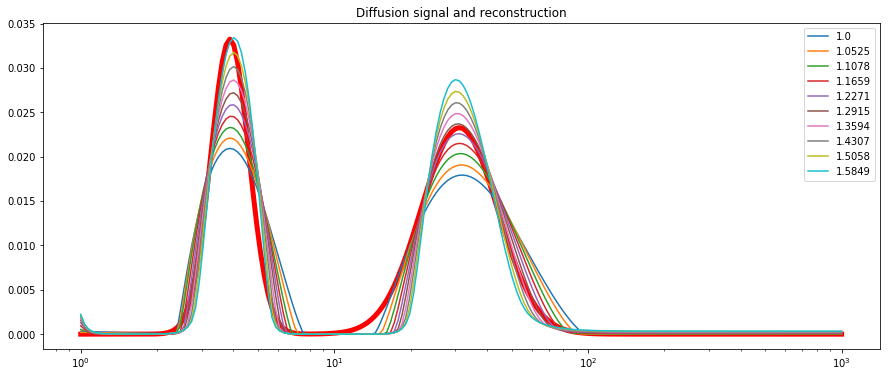

In [305]:
f, ax1 = plt.subplots(1, 1, figsize=(15,6))
ax1.set_xscale('log')
ax1.set_title('Diffusion signal and reconstruction')
ax1.plot(T,data,linewidth=5, color='red')

errors={}
for gamma in np.logspace(0.0,0.2,10):
    x_reconstructed = Douglas_Rachford(noisy, beta=0.00003, gamma=gamma, lambda_= 1/5, tol= 1e-6)
    errors[gamma] = Normalized_quadratic_error(data,x_reconstructed)
    ax1.plot(T, x_reconstructed, label='{}'.format(round(gamma,4)))
ax1.legend()

list(errors.items() )

**NB**: The best choice of parameter for optimizing using Douglas Rachford seems to be $\gamma=1.35$ and $\beta=3e^{-5}$

## 4 (bis) Forward-Backward implementation

Again, the function $g(x) = \frac{1}{2}\|Kx - y \|^{2}_{2}$ is in $\Gamma_0(H)$ and differentiable with a gradient that is $\nu$-Lipzitschian ($\nu$ = max{$\lambda$ for $\lambda$ in Spectre($K^{t}K$)) $\in R^{+}$). The function $f(x) = \beta ent(x)$ is in $\Gamma_0(H)$ and we already computed its image by the proximal operator.

Hence, since Argmin(f + g) ≠ {}, the problem can be solved by using forward-backward algorithm to obtain a sequence that weakly converges to a minimizer of f+g.

In [322]:
def Forward_Backward_2(signal, K=K, beta=1, tol= 1e-5):
    
    H = K.T.dot(K)
    eig_val, eig_vec = np.linalg.eig(H)
    nu = np.max(eig_val)
    
    #nu = np.max(np.linalg.eigvals(K.T.dot(K)))
    gamma = 2/(nu*1.01)
    delta = 2 - gamma*nu/2 
    lambda_= 1/2 #delta - 0.1
    print('beta={}, nu={}, gamma={}, delta={}'.format(beta,nu,gamma,delta))
                 
    grad_g = lambda x: K.T.dot(K).dot(x) - K.T.dot(signal)
    prox_f = lambda y: (beta*gamma)*lambertw(np.exp(y/(gamma*beta)-1)/(gamma*beta))
                         
    tolerance=1
                 
    x_n = np.zeros(200) #np.random.uniform(0,1,200)
    count=0
                         
    while tolerance > tol:
        count+=1   
        if count%1000==0:
            print(count, tolerance, tol) 
        if count%1000==0:
            lambda_=lambda_*0.99    
            
            #print(lambertw(np.exp(y_n/beta*gamma - 1 - np.log(gamma*beta))))
        y_n = x_n - gamma*grad_g(x_n)
        x_n1 = x_n + lambda_*(prox_f(y_n)-x_n) 
        tolerance = np.linalg.norm(x_n1 - x_n)**2/np.linalg.norm(x_n)**2
        x_n = x_n1            
    return x_n

beta=0.006, nu=(478.37995937073583+0j), gamma=(0.004139383310301597+0j), delta=(1.00990099009901+0j)


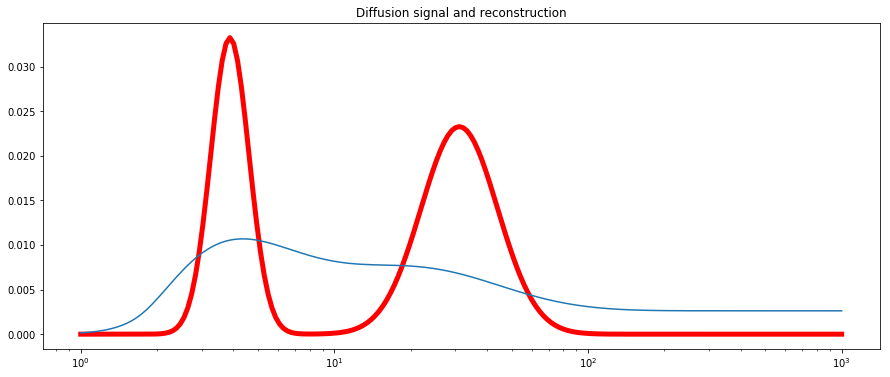

In [333]:
f, ax1 = plt.subplots(1, 1, figsize=(15,6))
ax1.set_xscale('log')
ax1.set_title('Diffusion signal and reconstruction')
ax1.plot(T,data,linewidth=5, color='red')

#for beta in np.logspace(-5,5,10):
x_reconstructed = Forward_Backward_2(noisy, K=K, beta=0.006, tol= 1e-8)
plt.plot(T, x_reconstructed)

**NB**: Forward_backward is less stable than Douglas-Rachford. Here the best choice of parameter that keeps a total solution over T seems to be $\beta=6e^{-3}$

### 4 (ter) Comparisons of the 2 methods for $\beta$ = $10^{-2}$

beta=0.01, nu=(478.37995937073583+0j), gamma=(0.004139383310301597+0j), delta=(1.00990099009901+0j)
gamma=1.5848931924611136, lambda=0.2,beta=0.01
error for F-B : 0.5722005760458672
error for D-R : 0.546010157641595
Error difference 0.026190418404272164


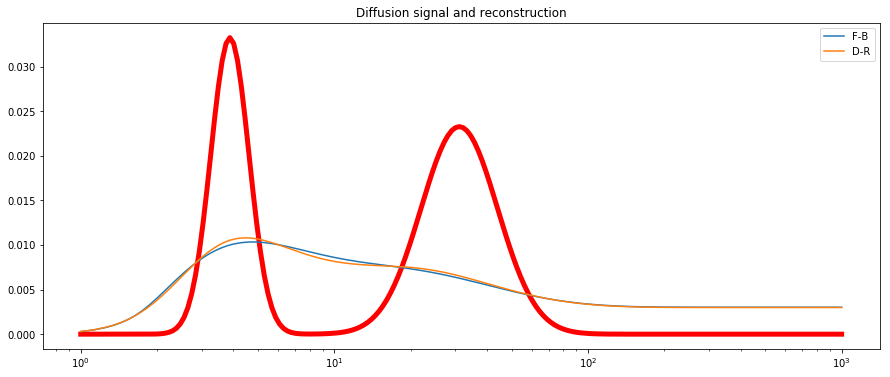

In [321]:
f, ax1 = plt.subplots(1, 1, figsize=(15,6))
ax1.set_xscale('log')
ax1.set_title('Diffusion signal and reconstruction')
ax1.plot(T,data,linewidth=5, color='red')

#for beta in np.logspace(-5,5,10):
x_reconstructed = Forward_Backward_2(noisy, K=K, beta=0.01, tol= 1e-8)
x_reconstructed2 = Douglas_Rachford(noisy, beta=0.01, gamma=gamma, lambda_= 1/5, tol= 1e-6)
print('error for F-B :',Normalized_quadratic_error(data,x_reconstructed))
print('error for D-R :',Normalized_quadratic_error(data,x_reconstructed2))
print('Error difference',(Normalized_quadratic_error(data,x_reconstructed)-Normalized_quadratic_error(data,x_reconstructed2)))
plt.plot(T, x_reconstructed,label='F-B')
plt.plot(T, x_reconstructed2,label='D-R')
plt.legend()



__Answer 7__ The new formulation with the entropy seems justified regarding the result of the reconstruction using Douglas-Rachford. The error is lower and the reconstruction visually satisfying for a rather straight-forward formulation and the time of convergence is comparable to previous method when we set the tolerance criteria to 1e-8. However it requires again to sport the best regularization parameter $\beta$ for providing a good reconstruction wich might be difficult in practice.

 ## 8 Implementation of PPXA+

In practice, adjusting the parameter β may be difficult, while one has often informations about the level of noise corrupting the data. A more practical formulation may therefore be obtained by solving the following optimization problem :

$$\min ent(x)$$ 
$$s.t \|Kx - y \|^{2}_{2} ≤ \eta M\sigma^{2}$$ 

This problem can be solved using the **Alternative-direction Method of Multipliers** or the **PPXA+**.

> **PPXA+**

The problem can be rewritten as: 

$$\min_{R^{+N}} ent(x) + 1_{\|.- y \|^{2}_{2} ≤ \eta M\sigma^{2}}(Kx) = \min_{R^{+N}} g_1 \circ I_N x + g_2 \circ Kx$$ 

As stated previously, $I_N$ and $K$ are bounded linear operators of $\mathfrak{B}(R^N,R)$, and $g_1$ and $g_2$ are 2 functions from $\Gamma_0(R^{N})$. Hence we can build a sequence $x_n$ that converges weakly to a minimizer of $ent(x) + 1_{D(y,\sqrt{\eta M}\sigma)}(Kx)$.
To do so, we explicit the proximal operators of the 2 functions:

$$prox_{\gamma g_1}(x) = arg \min_{R^{N}} ent(u) + \|u-x \|^{2}_{2}$$

$$prox_{\gamma g_2}(x) = arg \min_{R^{N}} 1_{\|u-y \|^{2}_{2} ≤ \eta M\sigma^{2}}(u) + \|u-x \|^{2}_{2} = \mathfrak{P}_{D(y,\eta M \sigma)}(x) = y + \min(\sqrt{\eta M}\sigma,\|x-y\|_{2})\frac{x-y}{\|x-y\|_{2}}  $$

In [290]:
from scipy.special import lambertw
def PPA(signal, K=K, M=50, eta=1, gamma=1, sigma_2=sigma_2, lambda_=1/2, tol= 1e-5):
    
    print('ball ray={}'.format(eta*M*sigma_2))
    
    prox_g1 = lambda x: gamma*lambertw(np.exp(x/(gamma) - 1)/gamma) 
    prox_g2 = lambda x,r: (x-signal)/np.linalg.norm(x-signal)*np.minimum(r,np.linalg.norm(x-signal)) + signal
        
        
    x_n1 = np.zeros(200) #np.random.uniform(0,1,200) 
    x_n2 = np.zeros(50) #np.random.uniform(0,1,50) 
    v_n = np.linalg.inv(np.eye(len(K.T)) + K.T.dot(K)).dot(x_n1 + K.T.dot(x_n2))
    tolerance=1
    count=0
    
    while tolerance > tol: 
        count+=1
        if count%1000==0:
            print(count, tolerance, tol)
        
        y_n1 = prox_g1(x_n1)
        y_n2 = prox_g2(x_n2,sigma_2*np.sqrt(M*eta))
        
        c_n = np.linalg.inv(np.eye(len(K.T)) + K.T.dot(K)).dot(y_n1 + K.T.dot(y_n2))
        
        x_n1_ = x_n1 + lambda_*(2*c_n - v_n - y_n1)
        x_n2_ = x_n2 + lambda_*(K.dot(2*c_n - v_n) - y_n2)
        v_n_ = v_n + lambda_*(c_n-v_n)
        
        tolerance = np.linalg.norm(v_n_ - v_n,1)/np.linalg.norm(v_n,1)
        v_n = v_n_
        x_n1 = x_n1_
        x_n2 = x_n2_
        
    return v_n

ball ray=0.20000000046313354
1000 0.00012294664618755079 1e-05
2000 0.0001008655350509836 1e-05
3000 7.794946762159808e-05 1e-05
4000 6.191790638544386e-05 1e-05
5000 5.0881250517491174e-05 1e-05
6000 4.298993763771159e-05 1e-05
7000 3.712220113583379e-05 1e-05
8000 3.256399417955701e-05 1e-05
9000 2.893847999425498e-05 1e-05
10000 2.6006645327016604e-05 1e-05
11000 2.355427052969703e-05 1e-05
12000 2.1493356399040304e-05 1e-05
13000 1.9754459895396272e-05 1e-05
14000 1.8245224238868843e-05 1e-05
15000 1.6932947885850696e-05 1e-05
16000 1.5784934218676034e-05 1e-05
17000 1.4770511952338186e-05 1e-05
18000 1.3875652908741593e-05 1e-05
19000 1.3073328049693355e-05 1e-05
20000 1.2352590079482546e-05 1e-05
21000 1.1698743003980936e-05 1e-05
22000 1.1102712258189733e-05 1e-05
23000 1.055890748713925e-05 1e-05
24000 1.0063145202792512e-05 1e-05


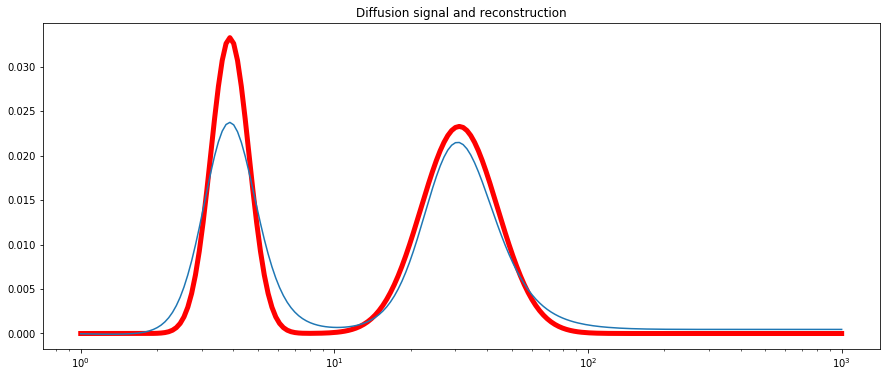

In [291]:
f, ax1 = plt.subplots(1, 1, figsize=(15,6))
ax1.set_xscale('log')
ax1.set_title('Diffusion signal and reconstruction')
ax1.plot(T,data,linewidth=5, color='red')


x_reconstructed = PPA(noisy, K=K, M=50, eta=0.4, gamma=1, sigma_2=sigma_2, lambda_=1/2, tol= 1e-5)
ax1.plot(T, x_reconstructed)


### ANNEXE: test of ADMM 

In [287]:
sigma_2 = 0.01*signal[0]
M = 50

def Douglas_Rachford_2(y, z, K=K, gamma=1, tol= 1e-5):
    
    nu = np.max(np.abs(np.linalg.eigvals(K.T.dot(K))))
   
    prox_g = lambda x,y,z: np.linalg.inv(K.T.dot(K)+np.eye(len(K.T))).dot(K.T.dot(y-z)+x)
    prox_f = lambda x: lambertw(np.exp(x*gamma - 1 + np.log(gamma)))/gamma                 
    
    tolerance = 1           
    x_n = np.zeros(200) #np.random.uniform(0,1,200)
    count=0
    
    while tolerance > tol: 
        count+=1
        if count%500==0:
            print(count, tolerance, tol)
            
        y_n = prox_g(x_n,y,z)
        z_n = prox_f(2*y_n - x_n)
        x_n1 = x_n + 0.5*(z_n-y_n)
        tolerance = np.linalg.norm(x_n1 - x_n,1)/np.linalg.norm(x_n,1)
        x_n = x_n1
      
    return y_n
def ADMM(signal,n_it=100, K=K, M=1, eta=1, gamma=1, sigma_2=sigma_2, tol= 1e-5):
    
    print('ball ray={}'.format(eta*M*sigma_2))
    
    argmin_f = lambda y,z: Douglas_Rachford_2(y, z, K=K, gamma=1, tol= 1e-2)
    proj_ball = lambda x,M,sigma_2,eta: (x-noisy)/np.maximum(M*eta*sigma_2,np.linalg.norm(x-noisy)) + noisy
                                              
    y_n = np.random.uniform(0,1,50) #np.zeros(50)     
    z_n = np.random.uniform(0,1,50) #np.zeros(50)
    tolerance=1
    x_n_prev = np.ones(200)
    count=0
    
    while tolerance > tol: 
        count+=1
        if count%10==0:
            print(count, tolerance, tol, np.linalg.norm(x_n-data))
            
        x_n = argmin_f(y_n,z_n) 
        s_n = K.dot(x_n)
        y_n1 = proj_ball(z_n + s_n, M,sigma_2,eta)
        z_n1 = z_n + s_n - y_n1
        tolerance = np.linalg.norm(x_n - x_n_prev,1)/np.linalg.norm(x_n_prev,1)
        x_n_prev = x_n
        z_n = z_n1
        y_n = y_n1
    return x_n

ball ray=0.20000000046313354
10 0.0029858687017453797 1e-13 0.15098239084069942
20 3.537847370232324e-05 1e-13 0.15115540467100655
30 5.079812707297108e-07 1e-13 0.15115812681870452
40 7.497858002704743e-09 1e-13 0.15115817149994268
50 1.1038401076925632e-10 1e-13 0.1511581721733638
60 1.6164144291876024e-12 1e-13 0.15115817218309235


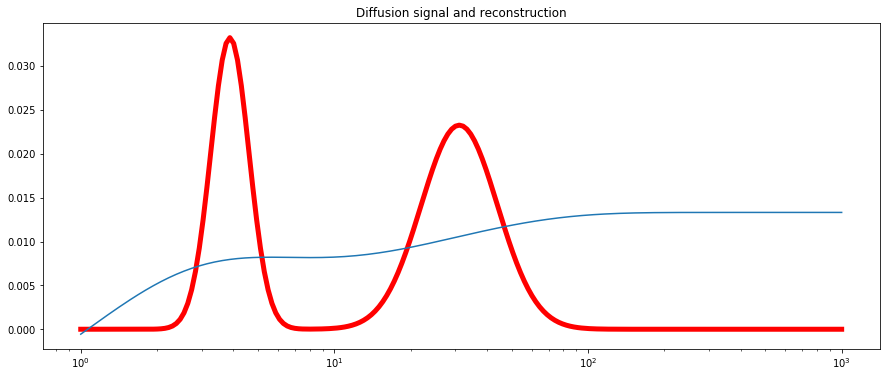

In [289]:
f, ax1 = plt.subplots(1, 1, figsize=(15,6))
ax1.set_xscale('log')
ax1.set_title('Diffusion signal and reconstruction')
ax1.plot(T,data,linewidth=5, color='red')


x_reconstructed = ADMM(signal,n_it=50, K=K, M=50, eta=0.4, gamma=1, sigma_2=sigma_2, tol= 1e-13)
ax1.plot(T, x_reconstructed)